# Farneback optic flow

In [61]:
import numpy as np
import cv2 as cv
out = False
# cap = cv.VideoCapture(cv.samples.findFile("asm2.mp4"))
cap = cv.VideoCapture('asm2.mp4')
ret, frame1 = cap.read()
oldframe = frame1
prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255
count = 1
all_mag = []
all_ang = []
while(1):
    ret, frame2 = cap.read()
    if ret:  # if the frame is non-empty:
        # if this is the same frame as before (repeated):
        meandiff = np.mean(np.array(oldframe) - np.array(frame2))
        # print('%02d' % meandiff, end=' ')
        if meandiff < 3:
            print('skip', end=' ')
            ret = False
        else:
            count += 1
            print(count, end=' ')
            # print('%01d' % np.mean(np.array(oldframe) - np.array(frame2)), end=' ')
            next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
            flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 20, 5, 7, 1.2, 0)
            mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])
            all_mag.append(mag)
            this_ang = ang*180/np.pi/2
            hsv[...,0] = this_ang
            all_ang.append(this_ang)
            hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)
            bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)
            # cv.imshow('frame2',bgr)
            if out:
                cv.imwrite('optical_fb%03d.png' % count, frame2)
                cv.imwrite('optical_hsv%03d.png' % count, bgr)
            prvs = next
            oldframe = frame2
    else:
        break

2 3 skip 4 5 6 7 skip 8 9 10 11 skip 12 13 14 15 skip 16 17 18 19 skip 20 21 22 23 skip 24 25 26 27 skip 28 29 30 31 skip 32 33 34 35 skip 36 37 38 39 skip 40 41 42 skip 43 44 45 46 skip 47 48 

In [62]:
npx_x = frame1.shape[0]
npx_y = frame1.shape[1]

# CWT

In [5]:
import matplotlib.pyplot as plt

In [63]:
all_mag = np.stack(all_mag, axis=2)
print(all_mag.shape)

(720, 1280, 47)


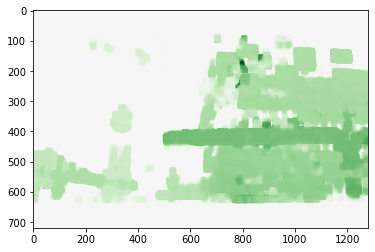

In [64]:
this_mag = all_mag[:, :, 10]
plt.imshow(this_mag, cmap='PRGn', aspect='auto', vmax=abs(this_mag).max(), vmin=-abs(this_mag).max())
plt.show()

In [65]:
nframes = all_mag.shape[2]
print('number of frames = ' + str(nframes))
freq_min = 1/nframes
print('frequency minimum = ' + str(freq_min))
freq_max = 30
print('frequency maximum = ' + str(freq_max))

number of frames = 47
frequency minimum = 0.02127659574468085
frequency maximum = 30


## <i>pywt</i> approach

In [89]:
import pywt

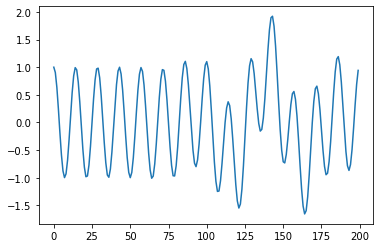

In [69]:
t = np.linspace(-1, 1, 200, endpoint=False)
sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
plt.plot(sig)
plt.show()

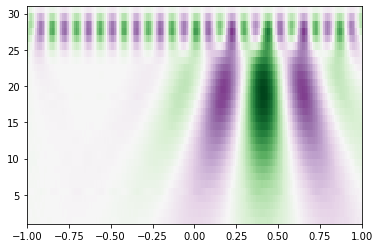

In [76]:
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
plt.show()

Text(0.5, 0, 'Time (sec)')

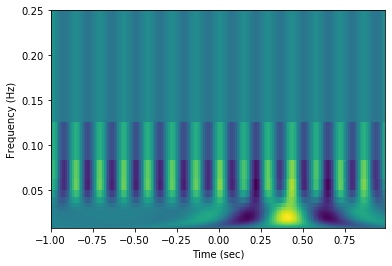

In [80]:
plt.pcolor(t, freqs, cwtmatr)
# plt.ylim([1, 100])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')

My own example -- in this case, a pixel across 47 frames.

https://stackoverflow.com/questions/43587314/frequency-axis-in-continuous-wavelet-transform-plot-scaleogram-in-python

In [81]:
ex_slice = all_mag[150, 1279, :]

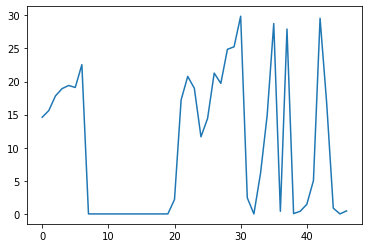

In [83]:
plt.plot(ex_slice)
plt.show()

In [110]:
widths = np.arange(1, nframes+1)
fs = 30.0
sampling_period = 1 / fs
cwtmatr, freqs = pywt.cwt(ex_slice, widths, 'mexh', sampling_period = sampling_period)

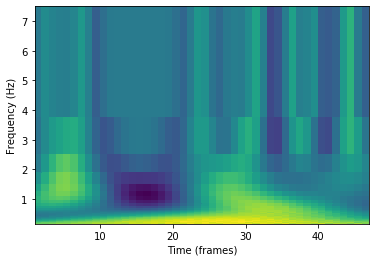

In [111]:
# plt.imshow(cwtmatr, cmap='PRGn', aspect='auto')
# plt.imshow(cwtmatr, cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.pcolor(widths, freqs, cwtmatr)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (frames)')
plt.show()

In [112]:
# indexing the low-frequency widths:
lf = np.intersect1d(np.where(freqs >= 0.3), np.where(freqs <=3))

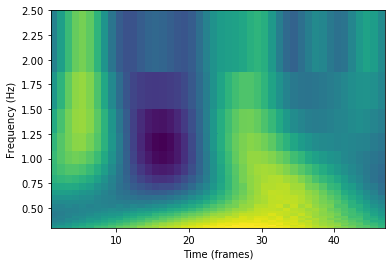

In [113]:
# plt.imshow(cwtmatr, cmap='PRGn', aspect='auto')
# plt.imshow(cwtmatr, cmap='PRGn', aspect='auto', vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.pcolor(widths, freqs[lf], cwtmatr[lf])
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (frames)')
plt.show()

Low frequency average:

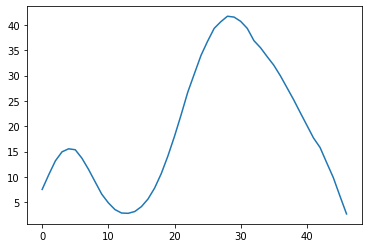

In [104]:
# plt.plot(np.mean(cwtmatr[(nframes-6):nframes, :], 0))
plt.plot(np.mean(cwtmatr[lf, :], 0))
plt.show()

# Magnitude <i>tf</i>

Pixel-wise Continuous Wavelet Transform.

For each pixel, we get the matrix representing temporal frequency spectra.

This is a very computationally expensive procedure: On my computer, it takes about 30 min to go through 1280 columns of pixels. It is definitely better to first extract global motion components and analyze those instead.

In [114]:
all_cwts = np.zeros((npx_x, npx_y, nframes, nframes), dtype=np.float32)
for y in range(0, npx_y):
    print(str(y), end=' ')
    for x in range(0, npx_x):
#         all_cwts.append(signal.cwt(flows[x, y, 0, :], signal.ricker, np.arange(1, nframes+1)))
#         all_cwts[x, y, :, :] = signal.cwt(all_mag[x, y, :], signal.ricker, np.arange(1, nframes+1))
        all_cwts[x, y, :, :], _ = pywt.cwt(all_mag[x, y, :], widths, 'mexh', sampling_period = sampling_period)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Make sure that we are indexing things correctly: Probing the pixel (150, 1279).

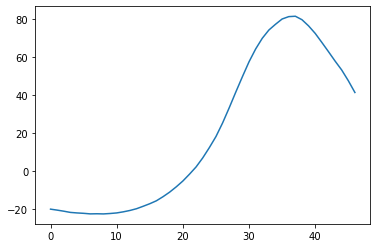

In [123]:
plt.plot(np.mean(all_cwts[350, 450, lf, :], 0))

Picking frequencies up to 3 Hz, which roughly corresponds to the CWT largest 5 widths (42 to 46 frames).

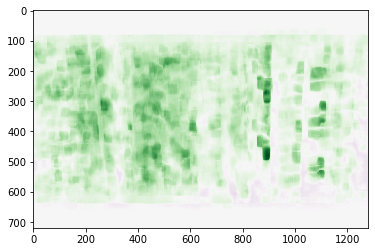

In [117]:
out = True
freq_hsv = np.zeros_like(frame1)
freq_hsv[...,1] = 255
freq_hsv[...,0] = 100
for cur_frame in range(0, nframes):
#     frame_freq = np.reshape(freq_lo[cur_frame, :], frame1.shape[0:2])
    frame_freq = np.mean(all_cwts[:, :, lf, cur_frame], 2)
    plt.imshow(frame_freq, cmap='PRGn', aspect='auto', vmax=abs(frame_freq).max(), vmin=-abs(frame_freq).max())
    plt.savefig('plt_lo%03d.png' % cur_frame)
#     print('min=' + str(np.min(frame_freq)))
#     print('max=' + str(np.max(frame_freq)))
#     freq_hsv[...,2] = cv.normalize(frame_freq,None,0,255,cv.NORM_MINMAX)
#     freq_bgr = cv.cvtColor(freq_hsv,cv.COLOR_HSV2BGR)
#     if out:
#         cv.imwrite('optical_lo%03d.png' % cur_frame, freq_bgr)

# Angle <i>tf</i>

In [119]:
all_ang = np.stack(all_ang, axis=2)
print(all_ang.shape)

(720, 1280, 47)


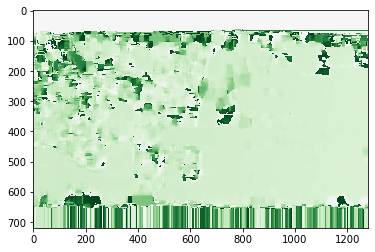

In [120]:
this_ang = all_ang[:, :, 10]
plt.imshow(this_ang, cmap='PRGn', aspect='auto', vmax=abs(this_ang).max(), vmin=-abs(this_ang).max())
plt.show()

In [121]:
ang_cwts = np.zeros((npx_x, npx_y, nframes, nframes), dtype=np.float32)
for y in range(0, npx_y):
    print(str(y), end=' ')
    for x in range(0, npx_x):
#         ang_cwts[x, y, :, :] = signal.cwt(all_ang[x, y, :], signal.ricker, np.arange(1, nframes+1))
        ang_cwts[x, y, :, :], _ = pywt.cwt(all_ang[x, y, :], widths, 'mexh', sampling_period = sampling_period)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Picking frequencies up to 3 Hz, which roughly corresponds to the CWT largest 5 widths (42 to 46 frames).

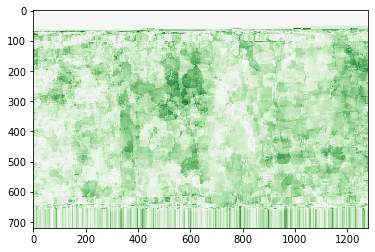

In [122]:
out = True
for cur_frame in range(0, nframes):
    frame_freq = np.mean(ang_cwts[:, :, lf, cur_frame], 2)
    plt.imshow(frame_freq, cmap='PRGn', aspect='auto', vmax=abs(frame_freq).max(), vmin=-abs(frame_freq).max())
    plt.savefig('ang_lo%03d.png' % cur_frame)

# To do

[x] assign hue depending on the sign and saturation depending on the value.

[x] convert output plots to gif's

[x] do the same for angles

[x] try an alternative wavelet implementation: <a href="https://pywavelets.readthedocs.io/en/latest/">pywt</a>. There seems to be a solution for converting samples to frequencies <a href="https://stackoverflow.com/questions/43587314/frequency-axis-in-continuous-wavelet-transform-plot-scaleogram-in-python">here</a>.